In [106]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

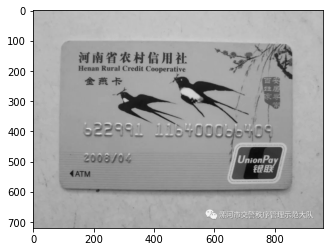

In [107]:
img = cv2.imread('img/card4.jpeg', 0)
plt.imshow(img, 'gray')

去除多余背景

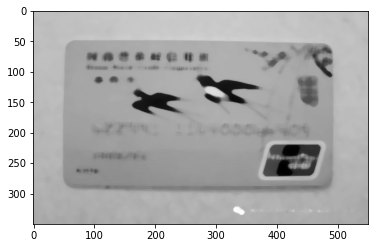

In [108]:
img = cv2.resize(img, (550, 350), 0, 0, cv2.INTER_NEAREST)
blur = cv2.medianBlur(img, 9)  # 中值滤波
plt.imshow(blur, 'gray')

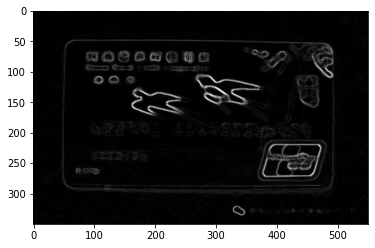

In [124]:
# 边缘检测的目的是标识数字图像中亮度变化明显的点。
x = cv2.Sobel(blur, cv2.CV_32F, 1, 0, 3)
y = cv2.Sobel(blur, cv2.CV_32F, 0, 1, 3)
absX = cv2.convertScaleAbs(x)  # 转为uint8格式
absY = cv2.convertScaleAbs(y)
# Sobel算子是在两个方向计算的，最后还需要用cv2.addWeighted( )函数将其组合起来。
sobel = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
plt.imshow(sobel, 'gray')

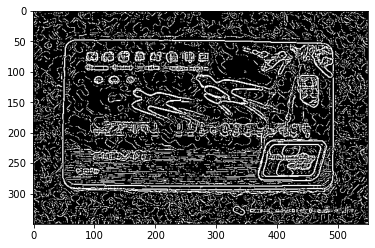

In [110]:
# 自适应二值化
thresh = cv2.adaptiveThreshold(sobel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3,0)

plt.imshow(thresh, 'gray')

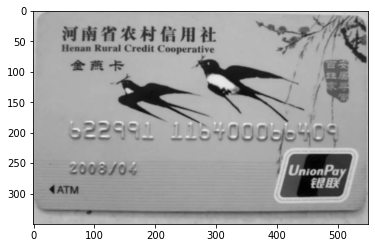

In [111]:
# 找到最大连通区域
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

temp = 0
W = 0
H = 0
X = 0
Y = 0
for i in range(0,len(cnts)):
    x,y,w,h = cv2.boundingRect(cnts[i])
    if(temp <w + h):    
        temp = w+h
        W = w
        H = h
        X = x
        Y = y  
remove_back_img = img[Y:Y+H,X:X+W]

img_r = cv2.resize(remove_back_img,(550, 350),cv2.INTER_NEAREST)
plt.imshow(img_r, 'gray')

划分银行卡号码区域

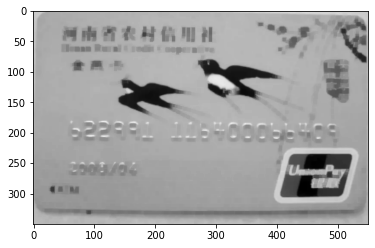

In [112]:
# 膨胀腐蚀
dilate = cv2.dilate(img_r, None, iterations=2)
erosion = cv2.erode(dilate, None, iterations=2)
plt.imshow(erosion, 'gray')

In [126]:
def embossment(img):  # 浮雕处理，将图像变化的部分突出
    H,W = img.shape
    dst = np.zeros((H,W),np.uint8)
    for i in range(0,H):
        for j in range(0,W-1):
            grayP0 = int(img[i,j])
            grayP1 = int(img[i,j+1])
            newP = grayP0 - grayP1 + 100
            if newP > 255:
                newP = 255
            if newP < 0:
                newP = 0
            dst[i,j] = newP
    return dst

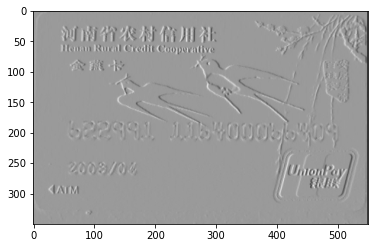

In [127]:
emboss_img = embossment(img_r)
plt.imshow(emboss_img, 'gray')

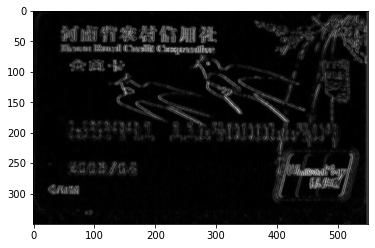

In [128]:
sobel_x = cv2.Sobel(emboss_img, cv2.CV_32F, 1, 0, 3)  # 边缘检测
sobel_y = cv2.Sobel(emboss_img, cv2.CV_32F, 0, 1, 3)
absX = cv2.convertScaleAbs(sobel_x)
absY = cv2.convertScaleAbs(sobel_y)
sobel_img = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)

plt.imshow(sobel_img, 'gray')

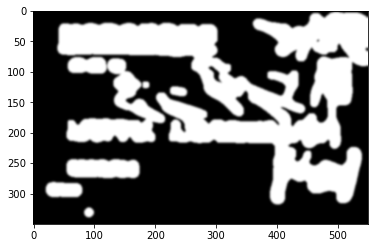

In [130]:
sobel_img = cv2.medianBlur(sobel_img, 11)  # 中值模糊
sobel_img = cv2.dilate(sobel_img, None, iterations=2)  # 膨胀

_, threshold = cv2.threshold(sobel_img, 10, 255, cv2.THRESH_BINARY)  # 二值化
threshold = cv2.GaussianBlur(threshold, (9, 9), 0)  # 高斯模糊

plt.imshow(threshold, 'gray')

In [131]:
def horizontal(img):  # 对竖直方向的黑色像素进行统计
    H, W = img.shape
    test_img = np.ones((H,W)) * 255
        
    hor_array = np.zeros(H, np.int32)
    for j in range(0, H):
        for i in range(0, W):
            if img[j, i] == 0:
                hor_array[j] += 1
                test_img[j,i] = 255
    for j in range(0,H):
        for i in range(0,hor_array[j]):
            test_img[j,i]=0
    # return hor_array
    return hor_array,test_img

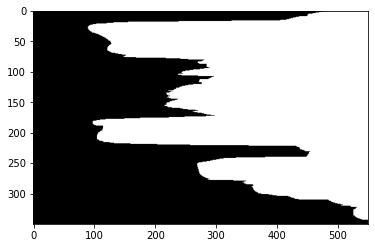

In [132]:
pixel_array, hor_img = horizontal(threshold)  # 对图形黑色像素进行竖直投影

plt.imshow(hor_img, 'gray')

In [133]:
def getArea(array):  # 找到黑色像素点最少的那一行，为银行卡卡号所在区域

    H = len(array)
    label_H = int(H / 10)
    min_ = sum(array)
    ans = 0
    for i in range(int(1/2 * H) - label_H):  # 从图像高2/5位置处开始进行平均值计算。
        a = int(2/5 * H) + i
        b = int(2/5 * H) + i + label_H
        mean = array[a:b].mean()
        if mean < min_:
            ans = a
            min_ = mean
        if a > 0.6 * H:
            return ans, ans+label_H

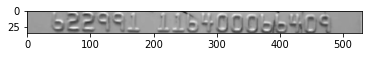

In [135]:
start, end = getArea(pixel_array)
res = img_r[start:end, 20:]

plt.imshow(res, 'gray')

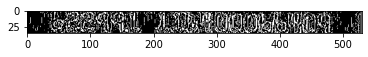

In [136]:
num_img = res

h, w = num_img.shape
dilate_img = embossment(num_img)
embo_img = cv2.medianBlur(dilate_img, 3)
thresh_img = cv2.adaptiveThreshold(
            dilate_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)  # 自适应二值化
plt.imshow(thresh_img, 'gray')

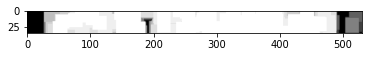

In [137]:
thresh_img = cv2.medianBlur(thresh_img, 3)
thresh_img = cv2.GaussianBlur(thresh_img, (3, 3), 0)
thresh_img = cv2.dilate(thresh_img, None, iterations=10)

# _, thresh_img = cv2.threshold(thresh_img, 220, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_img, 'gray')


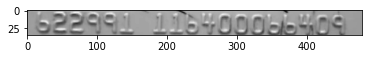

In [138]:
a = np.zeros(w, np.uint8)
for j in range(0, w):  # 计算水平方向上的黑色像素点数目，
    for i in range(0, h):
        if thresh_img[i, j] == 0:
            a[j] += 1

a = a[::-1]
length = int(0.75 * w)
min_ = sum(a)
start = 0
for i in range(len(a)):
    if a[i] < 15:
        a[i] = 0
    else:
        a[i] = 35
for i in range(w - length):
    end = i + length
    mean_ = a[i:end].mean()
    if(min_ > mean_ and i < 50):
        min_ = mean_
        start = i
end = w - start
a = a[::-1]
min_ = sum(a)
start = 0
for i in range(130):
    mean_ = a[i:end].mean()
    if min_ > mean_:
        min_ = mean_
        start = i

plt.imshow(num_img[:,start:end+10], 'gray')